In [1]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import pickle

# Functions

In [2]:
def round_up_to_nearest_five_minutes(ts):
    # Parse the timestamp
    dt = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
    
    # Calculate minutes to add to round up to the nearest 5 minutes
    minutes_to_add = (5 - dt.minute % 5) % 5
    if minutes_to_add == 0 and dt.second == 0:
        # If exactly on a 5 minute mark and second is 0, no need to add time
        minutes_to_add = 0
    
    # Add the necessary minutes
    new_dt = dt + timedelta(minutes=minutes_to_add)
    
    # Return the new timestamp in the same format
    return new_dt.strftime( "%d-%m-%Y %H:%M:%S")

In [3]:
# Need to set the 
def read_ohio(filepath, category, round):
    tree = ET.parse(filepath)
    root = tree.getroot()
    # interval_timedelta = datetime.timedelta(minutes=interval_timedelta)

    res = []
    for item in root.findall(category):
        entry0 = item[0].attrib
        if round == True:
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts'])
            entry0['ts'] = adjusted_ts
        ts = entry0['ts']
        entry0['ts'] = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        res.append([entry0])
        for i in range(1, len(item)):
            # last_entry = item[i - 1].attrib
            entry = item[i].attrib
            # t1 = datetime.datetime.strptime(entry["ts"], "%d-%m-%Y %H:%M:%S")
            # t0 = datetime.datetime.strptime(last_entry["ts"], "%d-%m-%Y %H:%M:%S")
            # delt = t1 - t0
            # if category == "glucose_level":
            #     if delt <= interval_timedelta:
            #         res[-1].append([entry])
            #     else:
            #         res.append([entry])
            # else:
            ts = entry['ts']
            if round == True:
                adjusted_ts = round_up_to_nearest_five_minutes(ts)
                entry['ts'] = adjusted_ts
            ts = entry['ts']
            entry['ts'] = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
            res.append([entry])
    return res


In [4]:
def transfer_into_table(glucose):
    glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in glucose}

    # Create the multi-channel database
    g_data = []
    for timestamp in glucose_dict:
        record = {
            'timestamp': timestamp,
            'glucose_value': glucose_dict[timestamp],
            # 'meal_type': None,
            # 'meal_carbs': 0
        }
        
        g_data.append(record)

    # Create DataFrame
    glucose_df = pd.DataFrame(g_data)

    # Convert glucose values to numeric type for analysis
    glucose_df['glucose_value'] = pd.to_numeric(glucose_df['glucose_value'])
    glucose_df['glucose_value'] = glucose_df['glucose_value'] / 100 # Shrink to its 1/100 for scaling

    return glucose_df

In [5]:
def segement_data_as_15min(data):
    df = pd.DataFrame(data)

    # Calculate time differences
    df['time_diff'] = df['timestamp'].diff()

    # Identify large gaps
    df['new_segment'] = df['time_diff'] > pd.Timedelta(minutes=15)

    # Find indices where new segments start
    segment_starts = df[df['new_segment']].index

    # Initialize an empty dictionary to store segments
    segments = {}
    prev_index = 0

    # Loop through each segment start and slice the DataFrame accordingly
    for i, start in enumerate(segment_starts, 1):
        segments[f'segment_{i}'] = df.iloc[prev_index:start].reset_index(drop=True)
        prev_index = start

    # Add the last segment from the last gap to the end of the DataFrame
    segments[f'segment_{len(segment_starts) + 1}'] = df.iloc[prev_index:].reset_index(drop=True)

    # Optionally remove helper columns from each segment
    for segment in segments.values():
        segment.drop(columns=['time_diff', 'new_segment'], inplace=True)
    
    return segments

In [6]:
# Function to align and update segments with meal data
def find_closest_glucose_index(glucose_df, meal_time, threshold_seconds=300):
    time_diffs = (glucose_df['timestamp'] - meal_time).abs()
    within_threshold = time_diffs < pd.Timedelta(seconds=threshold_seconds)
    if within_threshold.any():
        closest_index = time_diffs[within_threshold].idxmin()
        return closest_index
    return None

def update_segments_with_meals(segments, meal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['carbs'] = 0

        for index, meal_row in meal_df.iterrows():
            meal_time = meal_row['ts']
            closest_glucose_idx = find_closest_glucose_index(segment_df, meal_time)
            
            if closest_glucose_idx is not None:
                segment_df.loc[closest_glucose_idx, 'carbs'] = int(meal_row['carbs'])/100
                meal_df.loc[index, 'assigned'] = True


    return segments

# Implementation

In [9]:
filepath = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/train/570-ws-training.xml"
glucose = read_ohio(filepath, "glucose_level", True)
glucose_df = transfer_into_table(glucose)
segments = segement_data_as_15min(glucose_df)

In [10]:
segments["segment_1"]

,timestamp,glucose_value
0,2021-12-07 16:30:00,1.01
1,2021-12-07 16:35:00,1.00
2,2021-12-07 16:40:00,1.00
3,2021-12-07 16:45:00,0.99
4,2021-12-07 16:50:00,0.98
...,...,...
65,2021-12-07 21:55:00,1.44
66,2021-12-07 22:00:00,1.40
67,2021-12-07 22:05:00,1.39
68,2021-12-07 22:10:00,1.40


## Process meal logs

In [12]:
def find_closest_glucose_index(glucose_df, meal_time, threshold_seconds=300):
    time_diffs = (glucose_df['timestamp'] - meal_time).abs()
    within_threshold = time_diffs < pd.Timedelta(seconds=threshold_seconds)
    if within_threshold.any():
        closest_index = time_diffs[within_threshold].idxmin()
        return closest_index
    return None

def update_segments_with_meals(segments, meal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['carb_effect'] = 0

        for index, meal_row in meal_df.iterrows():
            meal_time = meal_row['ts']
            closest_glucose_idx = find_closest_glucose_index(segment_df, meal_time)
            
            if closest_glucose_idx is not None:
                segment_df.loc[closest_glucose_idx, 'carb_effect'] = int(meal_row['carb_effect'])/20
                meal_df.loc[index, 'assigned'] = True


    return segments

In [13]:
#Include meal:
meal = read_ohio(filepath, "meal", True)
flattened_meal_data = [item[0] for item in meal]  # Take the first (and only) item from each sublist
# Convert to DataFrame
meal_df = pd.DataFrame(flattened_meal_data)
meal_df['assigned'] = False
# Update the segments with meal data
# meal_updated_segments = update_segments_with_meals(interpolated_segements, meal_df)

In [14]:
def expand_meal_entry(meal_row):
    meal_time = meal_row['ts']
    end_effect_time = meal_time + timedelta(hours=3)
    carb = float(meal_row['carbs'])

    c_eff_list = [0, 0, 0, ]

    for i in range(1, 10):
        c_eff = (i * 0.111) * carb
        if c_eff > carb:
            print("C_eff > carb")
            c_eff = carb
        c_eff_list.append(c_eff)

    for j in range(1, 25):
        c_eff = (1 - (j * 0.028)) * carb
        if c_eff < 0:
            print("C_eff < 0")
            c_eff = 0
        c_eff_list.append(c_eff)

    timestamp_list = pd.date_range(start=meal_time, end=end_effect_time, freq='5min')
    d = {"ts": timestamp_list[:-1], "carb_effect": c_eff_list}
    meal_effect_df = pd.DataFrame(data = d)

    return meal_effect_df

    

In [15]:
empty_d = {"ts": [], "carb_effect": []}
whole_meal_effect_df = pd.DataFrame(data = empty_d)

for index, meal_row in meal_df.iterrows():
    meal_effect_df = expand_meal_entry(meal_row)

    # Merge the DataFrames on the 'ts' column with an outer join
    merged_df = pd.merge(whole_meal_effect_df, meal_effect_df, on='ts', how='outer', suffixes=('_df1', '_df2'))

    # Fill NaN values with 0 for the carb_effect columns
    merged_df['carb_effect_df1'] = merged_df['carb_effect_df1'].fillna(0)
    merged_df['carb_effect_df2'] = merged_df['carb_effect_df2'].fillna(0)

    # Sum the carb_effect values
    merged_df['carb_effect'] = merged_df['carb_effect_df1'] + merged_df['carb_effect_df2']

    # Keep only the required columns
    whole_meal_effect_df = merged_df[['ts', 'carb_effect']]
    

In [16]:
whole_meal_effect_df['assigned'] = False

C:\Users\username\AppData\Local\Temp\ipykernel_15572\3730447383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_meal_effect_df['assigned'] = False


In [17]:
np.average(whole_meal_effect_df['carb_effect'])

60.6719917669411

In [18]:
# Need to make it align with the CGM data
meal_updated_segments = update_segments_with_meals(segments, whole_meal_effect_df)

C:\Users\username\AppData\Local\Temp\ipykernel_15572\2117006920.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.35' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.loc[closest_glucose_idx, 'carb_effect'] = int(meal_row['carb_effect'])/20
C:\Users\username\AppData\Local\Temp\ipykernel_15572\2117006920.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.loc[closest_glucose_idx, 'carb_effect'] = int(meal_row['carb_effect'])/20
C:\Users\username\AppData\Local\Temp\ipykernel_15572\2117006920.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.4' has dtype incompatible with int64, p

## Process bolus info

In [19]:
def read_ohio_bolus_tempbasal(filepath, category, round):
    tree = ET.parse(filepath)
    root = tree.getroot()
    # interval_timedelta = datetime.timedelta(minutes=interval_timedelta)

    res = []
    for item in root.findall(category):
        if len(item) == 0:
            continue  # Skip if the item has no children
            
        entry0 = item[0].attrib
        if round == True:
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts_begin'])
            entry0['ts_begin'] = adjusted_ts
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts_end'])
            entry0['ts_end'] = adjusted_ts
        
        entry0['ts_begin'] = datetime.strptime(entry0['ts_begin'], "%d-%m-%Y %H:%M:%S")
        entry0['ts_end'] = datetime.strptime(entry0['ts_end'], "%d-%m-%Y %H:%M:%S")

        res.append([entry0])
        for i in range(1, len(item)):
            # last_entry = item[i - 1].attrib
            entry = item[i].attrib
            ts_begin = entry['ts_begin']
            ts_end = entry['ts_end']
            if round == True:
                adjusted_ts_begin = round_up_to_nearest_five_minutes(ts_begin)
                entry['ts_end'] = adjusted_ts_begin
                adjusted_ts_end = round_up_to_nearest_five_minutes(ts_end)
                entry['ts_end'] = adjusted_ts_end
            entry['ts_begin'] = datetime.strptime(entry['ts_begin'], "%d-%m-%Y %H:%M:%S")
            entry['ts_end'] = datetime.strptime(entry['ts_end'], "%d-%m-%Y %H:%M:%S")
            if category == "bolus":
                if entry['ts_begin'] != entry['ts_end']:
                    print("Unequal: begin: " + str(entry['ts_begin']) + "end: " + str(entry['ts_end']))
            res.append([entry])
    return res

In [20]:
# Include bolus:
bolus = read_ohio_bolus_tempbasal(filepath, "bolus", True)
flattened_bolus_data = [item[0] for item in bolus]  # Take the first (and only) item from each sublist
# Convert to DataFrame
bolus_df = pd.DataFrame(flattened_bolus_data)
# bolus_df['assigned'] = False
bolus_df


Unequal: begin: 2021-12-07 07:41:58end: 2021-12-07 08:15:58
Unequal: begin: 2021-12-07 18:31:52end: 2021-12-07 18:35:52
Unequal: begin: 2021-12-07 18:34:32end: 2021-12-07 19:05:32
Unequal: begin: 2021-12-07 22:19:46end: 2021-12-07 22:20:46
Unequal: begin: 2021-12-08 06:14:22end: 2021-12-08 06:15:22
Unequal: begin: 2021-12-08 06:18:52end: 2021-12-08 06:50:52
Unequal: begin: 2021-12-08 12:04:11end: 2021-12-08 12:05:11
Unequal: begin: 2021-12-08 12:09:16end: 2021-12-08 12:40:16
Unequal: begin: 2021-12-08 15:46:52end: 2021-12-08 15:50:52
Unequal: begin: 2021-12-08 16:48:48end: 2021-12-08 16:50:48
Unequal: begin: 2021-12-08 16:50:52end: 2021-12-08 17:20:52
Unequal: begin: 2021-12-08 19:21:27end: 2021-12-08 19:25:27
Unequal: begin: 2021-12-08 19:26:31end: 2021-12-08 20:00:31
Unequal: begin: 2021-12-08 21:34:33end: 2021-12-08 21:35:33
Unequal: begin: 2021-12-08 21:36:59end: 2021-12-08 22:10:59
Unequal: begin: 2021-12-09 05:24:38end: 2021-12-09 05:25:38
Unequal: begin: 2021-12-09 06:24:44end: 

,ts_begin,ts_end,type,dose,bwz_carb_input
0,2021-12-07 07:40:54,2021-12-07 07:40:54,normal dual,8.0,102
1,2021-12-07 07:41:58,2021-12-07 08:15:58,square dual,6.4,0
2,2021-12-07 18:31:52,2021-12-07 18:35:52,normal dual,4.0,65
3,2021-12-07 18:34:32,2021-12-07 19:05:32,square dual,4.1,0
4,2021-12-07 22:19:46,2021-12-07 22:20:46,normal,0.7,0
...,...,...,...,...,...
321,2022-01-16 13:48:12,2022-01-16 14:20:12,square dual,5.6,0
322,2022-01-16 18:44:39,2022-01-16 18:45:39,normal dual,4.8,60
323,2022-01-16 18:47:51,2022-01-16 19:20:51,square dual,3.8,0
324,2022-01-16 20:11:38,2022-01-16 20:15:38,normal dual,6.7,175


In [21]:
def expand_bolus_entry(bolus_row):
    bolus_time = bolus_row['ts_begin']
    timestamp_list = [bolus_time, ]
    # end_effect_time = bolus_time + timedelta(hours=3)
    dose = float(bolus_row['dose'])

    b_eff_list = [dose, ]
    b_eff = dose

    i = 1
    while b_eff > 0:
        b_eff = dose - (i * 0.07)
        b_eff_list.append(b_eff)
        timestamp_list.append(bolus_time + timedelta(minutes=5 * i))
        i += 1
    # print(len(timestamp_list[:-1]))
    # print(len(b_eff_list[:-1]))


    d = {"ts": timestamp_list[:-1], "bolus_effect": b_eff_list[:-1]}
    bolus_effect_df = pd.DataFrame(data = d)

    return bolus_effect_df

In [22]:
empty_b = {"ts": [], "bolus_effect": []}
whole_bolus_effect_df = pd.DataFrame(data = empty_b)

for index, bolus_row in bolus_df.iterrows():
    bolus_effect_df = expand_bolus_entry(bolus_row)

    # Merge the DataFrames on the 'ts' column with an outer join
    merged_df = pd.merge(whole_bolus_effect_df, bolus_effect_df, on='ts', how='outer', suffixes=('_df1', '_df2'))

    # Fill NaN values with 0 for the carb_effect columns
    merged_df['bolus_effect_df1'] = merged_df['bolus_effect_df1'].fillna(0)
    merged_df['bolus_effect_df2'] = merged_df['bolus_effect_df2'].fillna(0)
    

    # Sum the carb_effect values
    merged_df['bolus_effect'] = merged_df['bolus_effect_df1'] + merged_df['bolus_effect_df2']

    # Keep only the required columns
    whole_bolus_effect_df = merged_df[['ts', 'bolus_effect']]


In [23]:
whole_bolus_effect_df["assigned"] = False

C:\Users\username\AppData\Local\Temp\ipykernel_15572\953268531.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_bolus_effect_df["assigned"] = False


In [24]:
np.average(whole_bolus_effect_df["bolus_effect"])

3.980957724514357

In [25]:
def update_segments_with_bolus(segments, bolus_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['bolus_effect'] = 0

        for index, bolus_row in bolus_df.iterrows():
            bolus_time = bolus_row['ts']
            closest_glucose_idx = find_closest_glucose_index(segment_df, bolus_time)
            
            if closest_glucose_idx is not None:
                segment_df.loc[closest_glucose_idx, 'bolus_effect'] = float(bolus_row['bolus_effect']) /2
                bolus_df.loc[index, 'assigned'] = True


    return segments

In [26]:
# Need to make it align with the CGM data
bolus_updated_segments = update_segments_with_bolus(meal_updated_segments, whole_bolus_effect_df)

C:\Users\username\AppData\Local\Temp\ipykernel_15572\1956024289.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.32499999999999973' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.loc[closest_glucose_idx, 'bolus_effect'] = float(bolus_row['bolus_effect']) /2
C:\Users\username\AppData\Local\Temp\ipykernel_15572\1956024289.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.31999999999999984' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.loc[closest_glucose_idx, 'bolus_effect'] = float(bolus_row['bolus_effect']) /2
C:\Users\username\AppData\Local\Temp\ipykernel_15572\1956024289.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '

## Process step info

In [27]:
# filepath = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/train/559-ws-training.xml"
steps = read_ohio(filepath, "basis_steps", True)
flattened_steps_data = [item[0] for item in steps]  # Take the first (and only) item from each sublist
# Convert to DataFrame
step_df = pd.DataFrame(flattened_steps_data)
# step_df['assigned'] = False

In [28]:
def compute_accumulated_step(window_list, step_df):
    start_time = window_list[0]
    end_time = window_list[-1]

    step_list = []
    counter = 1
    for idx, step_row in step_df.iterrows():
        
        if step_row['ts'] >= start_time and step_row['ts'] < end_time:
            step_list.append(counter * float(step_row['value']))
            counter += 1

        if step_row['ts'] >= end_time:
            break
    # print("length of step_list ", len(step_list))
    if len(step_list) == 0:
        return None
    accumulate_step = sum(step_list)/len(step_list)
    return accumulate_step
    

In [29]:
accumulate_step_list = []
# test_segment = segments["segment_1"]
for segment_name, segment_df in bolus_updated_segments.items():
    accumulate_step_list = []
    for index, cgm_row in segment_df.iterrows():
        current = cgm_row['timestamp']
        first_timestamp = current - timedelta(minutes=50)
        window_list = pd.date_range(start=first_timestamp, end=current, freq='5min')

        accumulated_step = compute_accumulated_step(window_list, step_df)
        accumulate_step_list.append(accumulated_step)
    segment_df['steps'] = accumulate_step_list

In [30]:
bolus_updated_segments

{'segment_1':              timestamp  glucose_value  carb_effect  bolus_effect      steps
 0  2021-12-07 16:30:00           1.01         0.00         0.290   0.000000
 1  2021-12-07 16:35:00           1.00         0.00         0.255   0.000000
 2  2021-12-07 16:40:00           1.00         0.00         0.220   0.000000
 3  2021-12-07 16:45:00           0.99         0.00         0.185        NaN
 4  2021-12-07 16:50:00           0.98         0.00         0.150        NaN
 ..                 ...            ...          ...           ...        ...
 65 2021-12-07 21:55:00           1.44         0.05         0.565   3.000000
 66 2021-12-07 22:00:00           1.40         0.05         0.530   2.666667
 67 2021-12-07 22:05:00           1.39         0.10         0.495   2.400000
 68 2021-12-07 22:10:00           1.40         0.10         0.460   7.800000
 69 2021-12-07 22:15:00           1.40         0.15         0.350  13.600000
 
 [70 rows x 5 columns],
 'segment_2':                timestam

In [31]:
# Specify the file name
filename = '570_combined_segments.pkl'

# Save the dictionary to a file
with open(filename, 'wb') as f:
    pickle.dump(bolus_updated_segments, f)


In [9]:
filename = '559_combined_segments.pkl'
# Load the dictionary from the file
with open(filename, 'rb') as f:
    loaded_df_dict = pickle.load(f)

# Verify the content

print(loaded_df_dict['segment_1'])
print(loaded_df_dict['segment_2'])


EOFError: Ran out of input

In [9]:
bolus_updated_segments = loaded_df_dict

# Prepare dataset for training

In [57]:
def prepare_dataset(segments, ph, history):
    '''
    ph = 6, 30 minutes ahead
    ph = 12, 60 minutes ahead
    '''
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        segment_df['carb_effect'] = pd.to_numeric(segment_df['carb_effect'], errors='coerce')
        segment_df['steps'] = pd.to_numeric(segment_df['steps'], errors='coerce')
        segment_df['steps'] = segment_df['steps'] / 20
        segment_df['bolus_effect'] = pd.to_numeric(segment_df['bolus_effect'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        max_index = len(segment_df) - (history-1+ph+1)  # Subtracting 22 because we need to predict index + 21 and need index + history-1 to exist
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index + 1):
            # Extracting features from index i to i+history-1
            features = segment_df.loc[i:i+history-1, ['glucose_value', 'carb_effect', 'bolus_effect', 'steps']] # .values.flatten() # 'carb_effect', 'bolus_effect', 'steps'
            # Extracting label for index i+21
            # Do the label transform
            label = segment_df.loc[i+history-1+ph, 'glucose_value'] - segment_df.loc[i+history-1, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+history-1+ph, 'glucose_value'])
            features_list.append(features)
            labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    print("len of labels_list " + str(len(labels_list)))
    # new_labels_list = label_delta_transform(labels_list)    
    # print("after label transform. the len of label list "+str(len(new_labels_list)))    
    return features_list, labels_list, raw_glu_list

In [58]:
# Check whether bolus_updated_segments is updated with 

# Prepare for training
features_list, labels_list, raw_glu_list = prepare_dataset(bolus_updated_segments, 6, 24)

# Build training and validation loader
features_array = np.array(features_list)
labels_array = np.array(raw_glu_list) # Maybe need to replace this

# For one channel
# data_sequences = np.reshape(features_array, (features_array.shape[0], features_array.shape[1], 1))

X_train, X_val, y_train, y_val = train_test_split(features_array, labels_array, test_size=0.2, shuffle= False)

len of features_list 10402
len of labels_list 10402


In [59]:
X_train.shape

(8321, 24, 4)

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# class StackedLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(StackedLSTMModel, self).__init__()
#         self.hidden_size = hidden_size

#         # First LSTM layer
#         self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True).to(device)

#         # Dropout layer
#         self.dropout = nn.Dropout(0.2).to(device)

#         # Second LSTM layer
#         self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True).to(device)

#         # First Dense layer
#         self.fc1 = nn.Linear(hidden_size, 512).to(device)

#         # Second Dense layer
#         self.fc2 = nn.Linear(512, 128).to(device)

#         # Output layer
#         self.fc3 = nn.Linear(128, num_classes).to(device)

#     def forward(self, x):
#         # h0 = torch.zeros(x.size(0), self.hidden_size).to(x.device)
#         # c0 = torch.zeros(x.size(0), self.hidden_size).to(x.device)


#         # Forward pass through first LSTM layer
#         out, _ = self.lstm1(x.view(len(x), 1, -1))

#         # Apply dropout
#         out = self.dropout(out)

#         # Forward pass through second LSTM layer
#         out, _ = self.lstm2(out)

#         # Pass through first Dense layer
#         out = self.fc1(out[:, -1, :])

#         # Pass through second Dense layer
#         out = self.fc2(out)

#         # Pass through output layer
#         out = self.fc3(out)

#         return out

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim


class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(StackedLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob).to(device)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 512).to(device)
        self.fc2 = nn.Linear(512, 128).to(device)
        self.fc3 = nn.Linear(128, output_size).to(device)
        
        # Activation functions
        self.relu = nn.ReLU()
        
    # def forward(self, x):
    #     # Initialize hidden and cell state for the first LSTM layer
    #     h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
    #     c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        
    #     # First LSTM layer
    #     out, (hn, cn) = self.lstm1(x, (h0, c0))
        
    #     # Dropout layer
    #     out = self.dropout(out)
        
    #     # Initialize hidden and cell state for the second LSTM layer
    #     h1 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
    #     c1 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        
    #     # Second LSTM layer
    #     out, (hn, cn) = self.lstm2(out, (h1, c1))
        
    #     # Fully connected layers
    #     out = out[:, -1, :]  # Get the last time step output
    #     out = self.relu(self.fc1(out))
    #     out = self.relu(self.fc2(out))
    #     out = self.fc3(out)  # Remove the exponential activation function
        
    #     return out
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size from the input tensor

        # Initialize hidden and cell state for the first LSTM layer
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # First LSTM layer
        out, (hn, cn) = self.lstm1(x, (h0, c0))
        
        # Dropout layer
        out = self.dropout(out)
        
        # Initialize hidden and cell state for the second LSTM layer
        h1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # Second LSTM layer
        out, (hn, cn) = self.lstm2(out, (h1, c1))
        
        # Fully connected layers
        out = out[:, -1, :]  # Get the last time step output
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out



In [63]:
# Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # The original batch size = 128, however, training on 128 cannot get the model fully trained, so change to 32.
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [64]:
X_train.shape

torch.Size([8321, 24, 4])

In [65]:
X_train[0]

tensor([[1.0100, 0.0000, 0.2900, 0.0000],
        [1.0000, 0.0000, 0.2550, 0.0000],
        [1.0000, 0.0000, 0.2200, 0.0000],
        [0.9900, 0.0000, 0.1850, 0.0000],
        [0.9800, 0.0000, 0.1500, 0.0000],
        [0.9800, 0.0000, 0.1150, 0.0000],
        [0.9500, 0.0000, 0.0800, 0.0000],
        [0.9400, 0.0000, 0.0450, 0.0000],
        [0.9200, 0.0000, 0.0100, 0.0000],
        [0.9000, 0.0000, 0.0000, 0.0000],
        [0.8700, 0.0000, 0.0000, 0.0000],
        [0.8600, 0.0000, 0.0000, 0.0000],
        [0.8500, 0.0000, 0.0000, 0.0000],
        [0.8500, 0.0000, 0.0000, 0.0000],
        [0.8600, 0.0000, 0.0000, 0.0000],
        [0.8500, 0.0000, 0.0000, 0.0000],
        [0.8500, 0.0000, 0.0000, 0.0000],
        [0.8600, 0.0000, 0.0000, 0.0000],
        [0.8500, 0.0000, 0.0000, 0.0000],
        [0.8300, 0.0000, 0.0000, 0.0000],
        [0.8800, 0.0000, 0.0000, 0.0000],
        [0.9300, 0.0000, 0.0000, 0.0000],
        [0.9500, 0.0000, 0.0000, 0.0000],
        [0.9600, 0.0000, 0.0000, 0

In [82]:
input_size = 4  # Number of input features
hidden_size = 128  # Hidden vector size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Single output
dropout_prob = 0.2  # Dropout probability



model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob) # input_size, hidden_size, num_layers, output_size, dropout_prob
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)


In [83]:
num_epochs =500
for epoch in range(num_epochs):
    model.train()
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')


c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/500], Training Loss: 0.0993
Epoch [2/500], Training Loss: 3.4017
Epoch [3/500], Training Loss: 1.8830
Epoch [4/500], Training Loss: 1.3812
Epoch [5/500], Training Loss: 1.1093
Epoch [6/500], Training Loss: 0.8871
Epoch [7/500], Training Loss: 0.9057
Epoch [8/500], Training Loss: 0.8221
Epoch [9/500], Training Loss: 0.8266
Epoch [10/500], Training Loss: 0.8648
Epoch [11/500], Training Loss: 0.7920
Epoch [12/500], Training Loss: 0.7709
Epoch [13/500], Training Loss: 0.6678
Epoch [14/500], Training Loss: 0.6954
Epoch [15/500], Training Loss: 0.6979
Epoch [16/500], Training Loss: 0.7457
Epoch [17/500], Training Loss: 0.7275
Epoch [18/500], Training Loss: 0.6936
Epoch [19/500], Training Loss: 0.7210
Epoch [20/500], Training Loss: 0.6573
Epoch [21/500], Training Loss: 0.7101
Epoch [22/500], Training Loss: 0.6964
Epoch [23/500], Training Loss: 0.6780
Epoch [24/500], Training Loss: 0.5976
Epoch [25/500], Training Loss: 0.6721
Epoch [26/500], Training Loss: 0.7192
Epoch [27/500], Train

In [84]:
model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())
        total_loss += loss.item()
    
    avg_loss = total_loss / len(val_loader)
    print(f'Test Loss: {avg_loss:.4f}')

Test Loss: 0.2879


c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [85]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = root_mean_squared_error(actuals,predictions)
print(f'RMSE on validation set: {rmse}')

RMSE on validation set: 0.39505788683891296


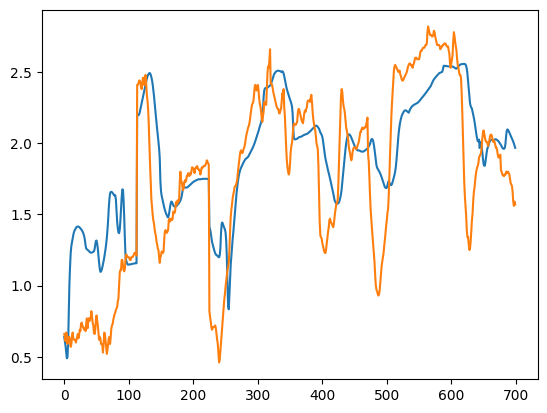

In [86]:
plt.plot(predictions[:700])
plt.plot(actuals[:700])

In [71]:
actuals

array([0.66, 0.64, 0.61, ..., 1.2 , 1.23, 1.28], dtype=float32)

# Testing

In [ ]:
filepath_test = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/test/570-ws-testing.xml"
glucose_test = read_ohio(filepath, "glucose_level", False)
glucose_df_test = transfer_into_table(glucose_test)
segments_test = segement_data_as_15min(glucose_df_test) # segment
# interpolated_segements_test = detect_missing_and_spline_interpolate(segments_test) #spline interpolate

